In [1]:
import sys

sys.path.insert(0, "/home/cristian/holisticai/src")

In [2]:
from holisticai.datasets import load_dataset
from holisticai.explainability.metrics import (
    tree_explainability_metrics
)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
# classification task
dataset = load_dataset('clinical_records', protected_attribute='sex', preprocessed=True)
train_test = dataset.train_test_split(test_size=0.2, random_state=42)

train = train_test['train']
test = train_test['test']

dataset

{"dtype":"Dataset","attributes":{"Instances":299,"Features":["X , y , p_attrs , group_a , group_b"]},"metadata":"sex: {'group_a': '0', 'group_b': '1'}"}

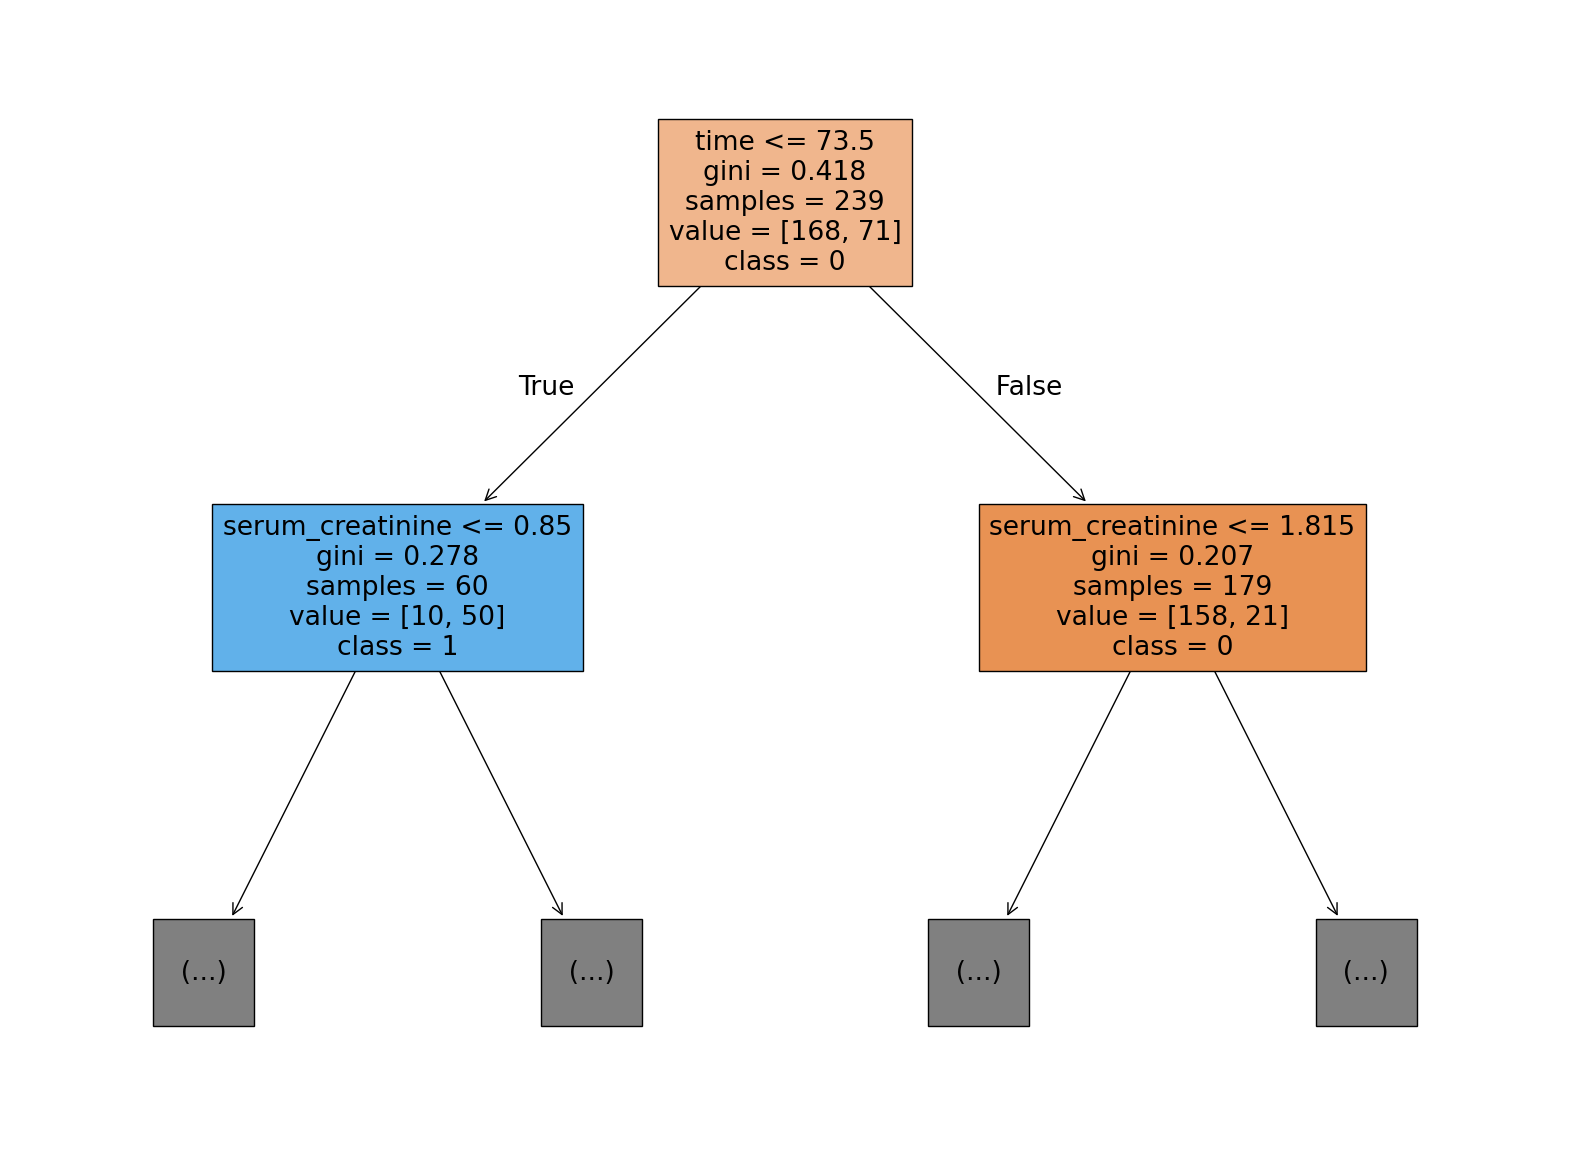

In [4]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train['X'], train['y'])
tree = clf.tree_

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plot_tree(clf, filled=True, max_depth=1, feature_names=train['X'].columns, class_names=['0', '1'])
plt.show()

In [5]:
# regression task
dataset = load_dataset('student', protected_attribute='sex', preprocessed=True)
train_test = dataset.train_test_split(test_size=0.2, random_state=42)

train = train_test['train']
test = train_test['test']

dataset

{"dtype":"Dataset","attributes":{"Instances":395,"Features":["X , y , p_attrs , group_a , group_b"]},"metadata":"sex: {'group_a': 'F', 'group_b': 'M'}"}

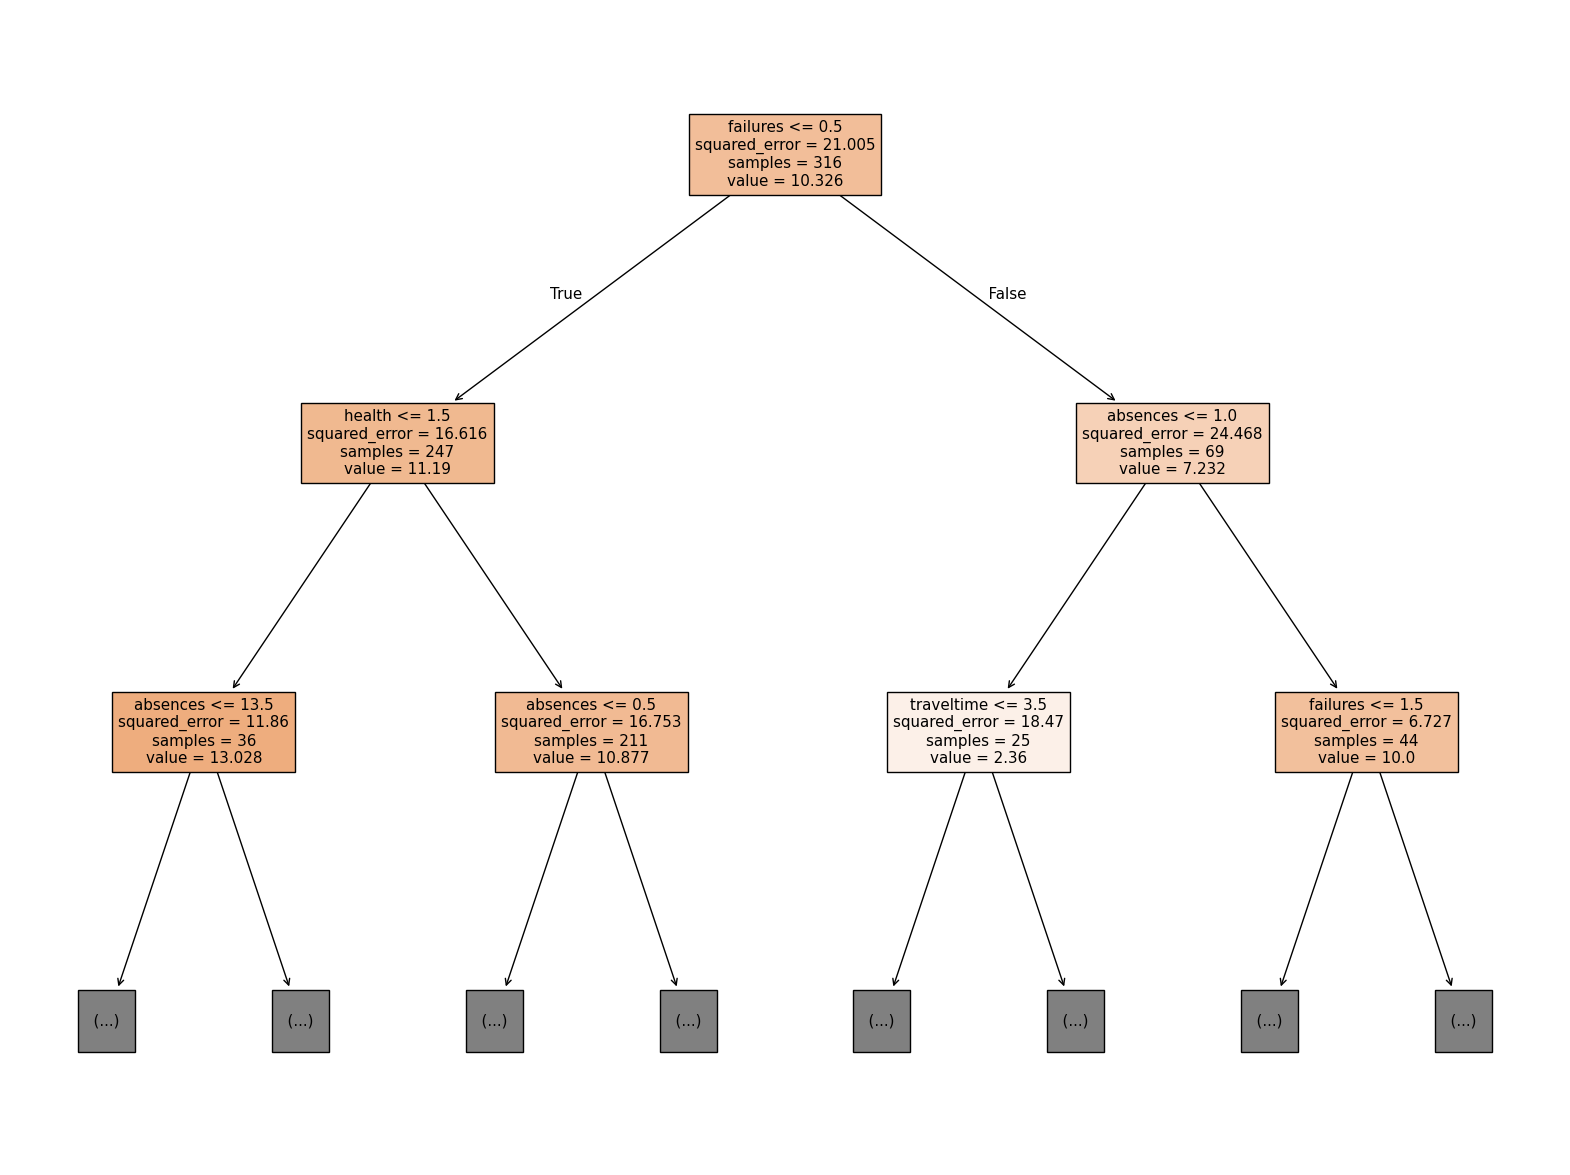

In [6]:
reg = DecisionTreeRegressor(random_state=42)
reg.fit(train['X'], train['y'])
tree = reg.tree_

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plot_tree(reg, filled=True, max_depth=2, feature_names=train['X'].columns)
plt.show()

## Weighted Average Depth (WAD)

- This metric weighs the depth of each leaf by the number of points of its associated cluster. To minimize it, large clusters shall be associated with shallower leaves (shorter explanation);
- For a partition $\mathcal{P}=(C_{1}, C_{2},\dots, C_{k})$ induced by a binary decision tree $\mathcal{D}$ with $k$ leaves, where the cluster $C_{i}$ is associated with the leaf $i$,
$$
WAD(\mathcal{D}) = \frac{\sum\limits_{i=1}^{k}\mid C_{i}\mid l_{i}}{n} 
$$
where $l_{i}$ is the number of conditions $i$ the path from the root to leaf $i$.

## Weighted Average Explanation Size (WAES)

- This metric replaces the depth of a leaf in WAD by the number of non-redundant tests in the path from root to the leaf;
- For a partition $\mathcal{P}=(C_{1}, C_{2},\dots, C_{k})$ induced by a binary decision tree $\mathcal{D}$ with $k$ leaves, where the cluster $C_{i}$ is associated with the leaf $i$,
$$
WAES(\mathcal{D}) = \frac{\sum\limits_{i=1}^{k}\mid C_{i}\mid l_{i}^{nr}}{n} 
$$
where $l_{i}^{nr}$ is the number of *non-redundant conditions* $i$ the path from the root to leaf $i$.


## Weighted Gini Node Impurity

The Gini index is a measure of the impurity of a node, with a lower Gini index indicating a better split. This can be extended to a weighted Gini index across all nodes, which gives a sense of how well the tree is splitting the data overall.

For a node $t$, the Gini index is given by:
$$GNI = 1 - \sum_{i=1}^{C} p_{i}^{2}$$
where $p_{i}$ is the proportion of samples of class $i$ in node $t$, and $C$ is the number of classes. For the entire tree, the weighted Gini index can be computed as:
$$WGNI = \sum_{t \in \text{leaves}} \frac{n_{t}}{N} G(t)$$
where $n_{t}$ is the number of samples in node $t$, and $N$ is the total number of samples in the tree.

The Gini index measures node impurity, with values ranging from 0 to 1:
- **Gini Index = 0:** Perfect purity, meaning all samples at a node belong to a single class.
- **Gini Index = 1:** Maximum impurity, meaning the samples are evenly distributed among all classes.

> **Good Performance:** In practice, a Gini index close to 0.1 or lower is considered good at individual nodes.
> **Intermediate Performance:** Values between 0.1 and 0.3 suggest that the split is decent but could be improved
> **Poor Performance:** Values above 0.3 typically indicate that the split isn't effective, and the node still contains a mix of classes.
> A **WGNI** for the entire tree should ideally be closer to 0, indicating that most nodes are pure or nearly pure.


## Tree Depth Variance

Tree depth variance measures how uniformly the tree's leaves are distributed in terms of depth. A high variance indicates that some branches are much deeper than others, which can signal overfitting or poor generalization, diminishing the explainability over different clusters.

For a set of leaf depths $\{d_1, d_2, \ldots, d_n\}$, the variance is calculated as:
$$TDV = \frac{1}{n} \sum_{i=1}^{n} (d_i - \mu_d)^2$$
where $\mu_d$ is the mean depth.

In [7]:
from holisticai.explainability.metrics import (
    weighted_average_depth, weighted_average_explainability_score,
    weighted_tree_gini, tree_depth_variance,
)

In [8]:
print('Weighted Average Depth:', weighted_average_depth(clf.tree_))
print('Weighted Average Explainability Score:', weighted_average_explainability_score(clf.tree_))
print('Weighted Tree Gini:', weighted_tree_gini(clf.tree_))
print('Tree Depth Variance:', tree_depth_variance(clf.tree_))

Weighted Average Depth: 5.702928870292886
Weighted Average Explainability Score: 5.142259414225941
Weighted Tree Gini: 0.9118976519003807
Tree Depth Variance: 3.575510204081632


In [9]:
# metrics for classification task
metrics = tree_explainability_metrics(clf.tree_)
metrics

,value,reference
metric,,
Weighted Average Depth,5.702929,0.0
Weighted Average Explainability Score,5.142259,0.0
Weighted Gini Index,0.911898,0.0
Tree Depth Variance,3.575510,0.0
Number of Rules,35.000000,1.0
Number of Features,8.000000,1.0


In [10]:
# metrics for regression task
metrics = tree_explainability_metrics(reg.tree_)
metrics

,value,reference
metric,,
Weighted Average Depth,10.300633,0.0
Weighted Average Explainability Score,9.398734,0.0
Weighted Gini Index,0.000000,0.0
Tree Depth Variance,9.422933,0.0
Number of Rules,225.000000,1.0
Number of Features,25.000000,1.0


In [11]:
from holisticai.explainability.metrics.tree import tree_number_of_rules

tree_number_of_rules(reg.tree_)

225

In [12]:
from holisticai.explainability.metrics.tree import tree_number_of_features

tree_number_of_features(reg.tree_)

25